## Desafio

Alguns estudantes decidem realizar prova do ENEM de forma precoce, como um teste (coluna `IN_TREINEIRO`). Nesse sentido, o desafio foi criar um modelo de classificação binária para inferir a mesma. Os resultados possíveis da resposta devem ser “0” ou “1”.

Para isso, foi utilizado a base de dados do ENEM 2016 disponíveis nos arquivos train.csv e teste.csv. A resposta foi salva em um arquivo chamado answer.csv com duas colunas: `NU_INSCRICAO` e `IN_TREINEIRO`.


Obs: Qualquer dúvida a respeito das colunas, consulte o [Dicionário dos Microdados do Enem 2016](https://s3-us-west-1.amazonaws.com/acceleration-assets-highway/data-science/dicionario-de-dados.zip).

### Setup

In [1]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Configuraçãoes do Matplotlib
plt.rc("figure", figsize=(10, 6))
sns.set(style="dark", palette="Accent")

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

### Análise Exploratória dos Dados

In [4]:
train.columns

Index(['Unnamed: 0', 'NU_INSCRICAO', 'NU_ANO', 'CO_MUNICIPIO_RESIDENCIA',
       'NO_MUNICIPIO_RESIDENCIA', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA',
       'NU_IDADE', 'TP_SEXO', 'TP_ESTADO_CIVIL',
       ...
       'Q041', 'Q042', 'Q043', 'Q044', 'Q045', 'Q046', 'Q047', 'Q048', 'Q049',
       'Q050'],
      dtype='object', length=167)

In [5]:
test.columns

Index(['NU_INSCRICAO', 'CO_UF_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE',
       'TP_SEXO', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO',
       'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'TP_ENSINO', 'TP_DEPENDENCIA_ADM_ESC',
       'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DISLEXIA',
       'IN_DISCALCULIA', 'IN_SABATISTA', 'IN_GESTANTE', 'IN_IDOSO',
       'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC', 'TP_PRESENCA_MT',
       'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA',
       'TP_STATUS_REDACAO', 'NU_NOTA_COMP1', 'NU_NOTA_COMP2', 'NU_NOTA_COMP3',
       'NU_NOTA_COMP4', 'NU_NOTA_COMP5', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q006', 'Q024', 'Q025', 'Q026', 'Q027', 'Q047'],
      dtype='object')

In [6]:
print(f'Shape do df de treino: {train.shape}\nShape do df de teste: {test.shape}')

Shape do df de treino: (13730, 167)
Shape do df de teste: (4570, 43)


Nota-se que o conjundo de dados de treino possui 13730 registros e 166 colunas. Enquanto, o conjundo de dados de teste possui somente 4576 registros e 47 colunas.

In [7]:
train['IN_TREINEIRO'].value_counts()

0    11947
1     1783
Name: IN_TREINEIRO, dtype: int64

In [31]:
#Analisando a porcentagem de treineiros no dataset
treneiros = train.IN_TREINEIRO.value_counts()[1]/train.IN_TREINEIRO.value_counts()[0] * 100
print(f'{round(treneiros, 2)}% dos participantes são treineiros')

14.92% dos participantes são treineiros


In [10]:
def plota_treineiros(classes):   
    sns.countplot(classes)
    plt.title("Proporção das Classes", fontsize=25)
    plt.ylabel("Quantidade", fontsize=18)
    plt.xlabel("Classes", fontsize=18)
    
    plt.grid(True)

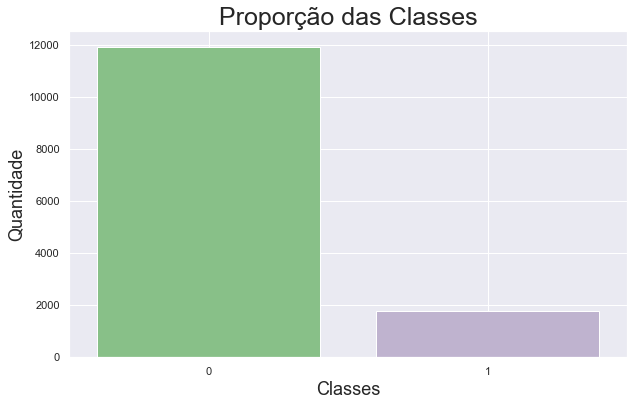

In [11]:
plota_treineiros(train["IN_TREINEIRO"])

### Feature Engineering

In [12]:
train.isna().sum()[train.isna().sum()>0].sort_values(ascending=False)

NO_ENTIDADE_CERTIFICACAO       12092
CO_UF_ENTIDADE_CERTIFICACAO    12092
SG_UF_ENTIDADE_CERTIFICACAO    12092
Q041                           10792
SG_UF_ESC                       9448
TP_LOCALIZACAO_ESC              9448
TP_SIT_FUNC_ESC                 9448
CO_UF_ESC                       9448
NO_MUNICIPIO_ESC                9448
CO_MUNICIPIO_ESC                9448
CO_ESCOLA                       9448
TP_ENSINO                       9448
TP_DEPENDENCIA_ADM_ESC          9448
Q032                            7376
Q031                            7376
Q028                            7376
Q033                            7376
Q030                            7375
Q029                            7375
Q027                            7373
NU_NOTA_COMP1                   3597
NU_NOTA_LC                      3597
NU_NOTA_REDACAO                 3597
NU_NOTA_MT                      3597
TP_STATUS_REDACAO               3597
NU_NOTA_COMP5                   3597
TX_RESPOSTAS_LC                 3597
T

In [13]:
train.isna().sum()[train.isna().sum()>0].sort_values(ascending=False)/train.shape[0]

NO_ENTIDADE_CERTIFICACAO       0.880699
CO_UF_ENTIDADE_CERTIFICACAO    0.880699
SG_UF_ENTIDADE_CERTIFICACAO    0.880699
Q041                           0.786016
SG_UF_ESC                      0.688128
TP_LOCALIZACAO_ESC             0.688128
TP_SIT_FUNC_ESC                0.688128
CO_UF_ESC                      0.688128
NO_MUNICIPIO_ESC               0.688128
CO_MUNICIPIO_ESC               0.688128
CO_ESCOLA                      0.688128
TP_ENSINO                      0.688128
TP_DEPENDENCIA_ADM_ESC         0.688128
Q032                           0.537218
Q031                           0.537218
Q028                           0.537218
Q033                           0.537218
Q030                           0.537145
Q029                           0.537145
Q027                           0.536999
NU_NOTA_COMP1                  0.261981
NU_NOTA_LC                     0.261981
NU_NOTA_REDACAO                0.261981
NU_NOTA_MT                     0.261981
TP_STATUS_REDACAO              0.261981


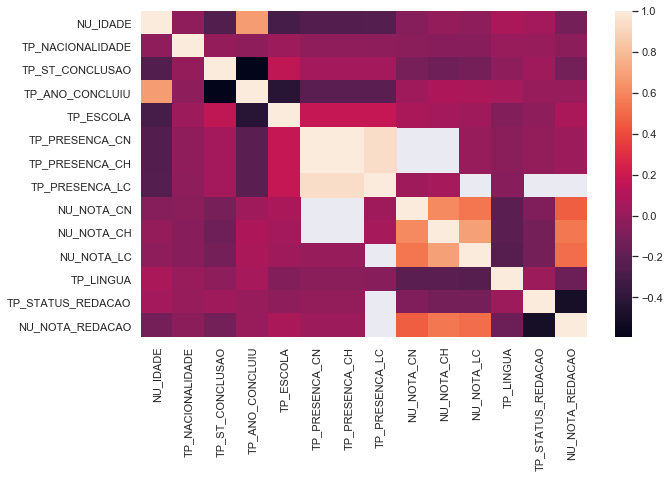

In [14]:
# Selecionando as features com menos dados faltantes para analisar a matriz de correlação
features = [
            'NU_IDADE',
            'TP_SEXO',
            'TP_NACIONALIDADE',
            'TP_ST_CONCLUSAO',
            'TP_ANO_CONCLUIU',
            'TP_ESCOLA',
            'TP_PRESENCA_CN',
            'TP_PRESENCA_CH',
            'TP_PRESENCA_LC',
            'NU_NOTA_CN',
            'NU_NOTA_CH',
            'NU_NOTA_LC',
            'TP_LINGUA',
            'TP_STATUS_REDACAO',
            'NU_NOTA_REDACAO',
            ]

sns.heatmap(train[features].corr())

In [15]:
target = 'IN_TREINEIRO'

In [16]:
cat_features = train[features].select_dtypes('object').columns # variáveis categóricas
num_features = train[features].select_dtypes('number').columns # variáveis numéricas

In [17]:
train = train.dropna( how='all', subset=[target] )

In [18]:
train[ cat_features ] = train[ cat_features ].fillna(-1).astype(str)
train[ num_features ] = train[ num_features ].fillna(-1)

test[ cat_features ] = test[ cat_features ].fillna(-1).astype(str)
test[ num_features ] = test[ num_features ].fillna(-1)

In [19]:

train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

### Aplicando o One-Hot-Enconder nas variáveis categóricas.

O one-hot-encoding transforma as variáveis categóricas em colunas binárias.

In [20]:
onehot = OneHotEncoder( sparse=False, handle_unknown='ignore' ).fit( train[cat_features] )

In [21]:
df_onehot = pd.DataFrame( onehot.transform( train[cat_features] ), columns= onehot.get_feature_names( cat_features ))

df_train = pd.concat( [train[num_features], df_onehot], axis=1, ignore_index=True)

In [22]:
onehot_teste = OneHotEncoder( sparse=False, handle_unknown='ignore' ).fit( test[cat_features] )

In [23]:
df_onehot_teste = pd.DataFrame( onehot_teste.transform( test[cat_features] ), columns=onehot_teste.get_feature_names( cat_features ))

df_test = pd.concat( [test[num_features], df_onehot_teste], axis=1, ignore_index=True)

### SMOTE

O desbalanceamento dos dados prejudica a geração de modelos de classificação, principalmente, em relação a identificação de casos da classe minoritária. Para balancear os dados de treinamento, foi utilizada a técnica SMOTE (Synthetic Minority Oversampling Technique), que amplia a amostra de treinamento com instâncias sintéticas da classe minoritária

In [24]:
smote = SMOTE(sampling_strategy="minority")
X_smote, y_smote = smote.fit_resample(df_train, train.IN_TREINEIRO)

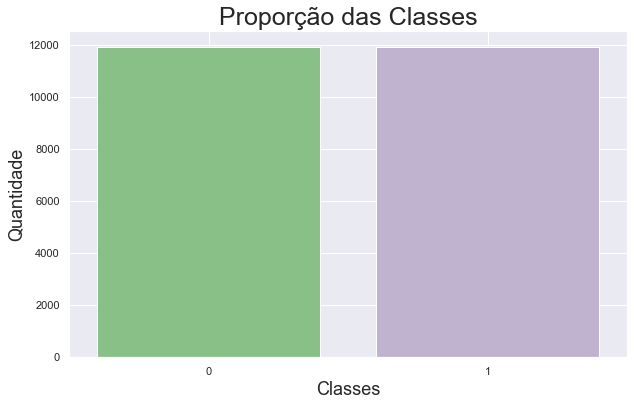

In [25]:
plota_treineiros(y_smote)

### Random Forest

O Random Forest é um algoritmo de aprendizagem supervisionada. O Random Forest cria uma floresta de um modo aleatório. Sendo que, esta “floresta” criado é uma combinação (ensemble) de árvores de decisão, na maioria dos casos treinados com o método de bagging. A idéia principal do método de bagging é que a combinação dos modelos de aprendizado aumenta o resultado geral.

In [26]:
forest = RandomForestClassifier()

forest.fit(X_smote, y_smote)

RandomForestClassifier()

In [27]:
classification = forest.predict(df_test)

Salvando as predições feitas no arquivo answer.csv para submeter na plataforma da Codenation

In [28]:
answer = test[['NU_INSCRICAO']].copy()
answer['IN_TREINEIRO'] = classification

In [29]:
answer.head()

,NU_INSCRICAO,IN_TREINEIRO
0,ba0cc30ba34e7a46764c09dfc38ed83d15828897,0
1,177f281c68fa032aedbd842a745da68490926cd2,0
2,6cf0d8b97597d7625cdedc7bdb6c0f052286c334,1
3,5c356d810fa57671402502cd0933e5601a2ebf1e,0
4,df47c07bd881c2db3f38c6048bf77c132ad0ceb3,0


In [30]:
answer.to_csv('answer.csv', index=False)

### Resultado 

Segundo a plataforma da codenation, esse modelo teve o score de 99.4967 %